In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family']='DFKai-SB' #顯示中文 (for Win10)
plt.rcParams['axes.unicode_minus']=False #正常顯示負號

pd.set_option("display.max_columns",50) #設定pandas最多顯示出50個欄位資訊

df = pd.read_csv('A_LVR_LAND_A.csv', encoding='big5') #台北市

In [38]:
# 去除土地和車位兩種交易資料
df = df[(df['交易標的']!='土地') & (df['交易標的']!='車位')].reset_index(drop=True)
#改成以萬為單位，方便圖表顯示
df.loc[:,'總價元'] = df.loc[:,'總價元']/10000 
for i in range(len(df)):
    df.loc[i,'交易年'] = round(df.loc[i,'交易年月日']/10000)
from datetime import datetime
now = datetime.now()
now.year #(年,月,日,時,分,秒,微秒) ps: 微秒(microseconds)=1/1000000秒
for i in range(len(df)):
    df.loc[i,'建築完成年'] = round(df.loc[i,'建築完成年月']/10000)
    df.loc[i,'屋齡'] = now.year - 1911 - round(df.loc[i,'建築完成年月']/10000)
#df.sample(5)

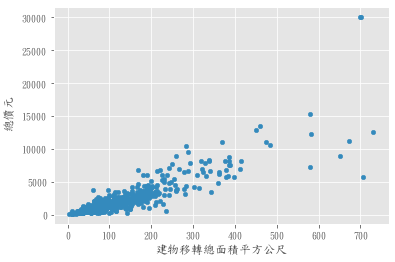

In [39]:
df = df[['鄉鎮市區','土地移轉總面積平方公尺','建物移轉總面積平方公尺','單價每平方公尺','建物現況格局-房','建物現況格局-廳','建物現況格局-衛','車位移轉總面積平方公尺','車位總價元','屋齡','建築完成年','交易年','總價元']]
df_ml = df.dropna().reset_index(drop=True)

df_ml = df_ml[df_ml['建物移轉總面積平方公尺']<1000]
df_ml.plot(kind='scatter',x='建物移轉總面積平方公尺',y='總價元')
#df_ml.sample(2)

### 拆分資料集(features)

In [40]:
from sklearn.model_selection import train_test_split

X = df_ml[['建物移轉總面積平方公尺']]
y = df_ml[['總價元']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 30% for testing, 70% for training
X_train.head()

,建物移轉總面積平方公尺
556,124.02
521,40.62
19,100.27
437,105.45
293,86.99


### 標準化(多次方項次標準化反而變差)

In [41]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#Compute the mean and std to be used for later scaling.
sc.fit(X_train)
#Perform standardization by centering and scaling
X_train_normalized = sc.transform(X_train)
X_test_normalized = sc.transform(X_test)

#SGDRegressor的input y需要一維矩陣type
y_train_1d = y_train.values.ravel()
y_test_1d = y_test.values.ravel()


In [42]:
print(type(X_train_normalized))
print(X_train_normalized[:5])
print(type(y_train_1d))
print(y_train_1d[:5])

<class 'numpy.ndarray'>
[[-0.0775111 ]
 [-0.84404036]
 [-0.29579731]
 [-0.24818794]
 [-0.41785377]]
<class 'numpy.ndarray'>
[1588.  605. 1266. 1288.  667.]


### 創造高次方項

In [43]:
from sklearn.preprocessing import PolynomialFeatures

quadratic = PolynomialFeatures(degree=2)
X_train_raw = X_train.copy() #原始X_train
X_test_raw = X_test.copy() #原始X_test
X_train_poly = quadratic.fit_transform(X_train_raw) #產生x^0, x^1, x^2
X_test_poly = quadratic.fit_transform(X_test_raw) #產生x^0, x^1, x^2

### 訓練模型

In [44]:
from sklearn import datasets, linear_model

# linear regression 物件
regr = linear_model.LinearRegression()

# 訓練模型
regr.fit(X_train_poly, y_train_1d)

print('各變項參數: \n', regr.coef_)
print("MSE: %.2f" % np.mean((regr.predict(X_test_poly) - y_test_1d) ** 2))
print("R Square:",regr.score(X_test_poly, y_test))


各變項參數: 
 [0.00000000e+00 1.50382059e+01 1.40610652e-02]
MSE: 749777.85
R Square: 0.7687364049609036


### 實際測試

In [45]:
regr.predict(quadratic.fit_transform(pd.DataFrame([100,200,300])))

array([1616.9434979 , 3542.5960449 , 5749.46989679])

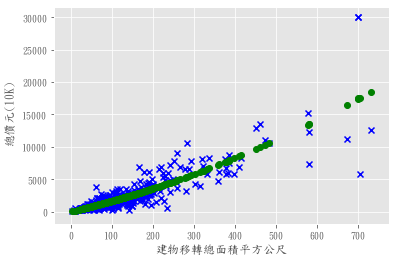

In [46]:
#訓練資料使用散步圖標示
plt.scatter(X_train['建物移轉總面積平方公尺'], y_train_1d,  color='blue', marker = 'x')
#預測直線使用線圖表示
plt.scatter((X_train['建物移轉總面積平方公尺']), regr.predict(X_train_poly), color='green', linewidth=1)

plt.ylabel('總價元(10K)')
plt.xlabel('建物移轉總面積平方公尺')

plt.show()

### K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)

In [47]:
# Scikit-Learn 官網作圖函式
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(10,6))  #調整作圖大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


<module 'matplotlib.pyplot' from 'C:\\Users\\jas72\\Anaconda3\\envs\\DarrenAI\\lib\\site-packages\\matplotlib\\pyplot.py'>

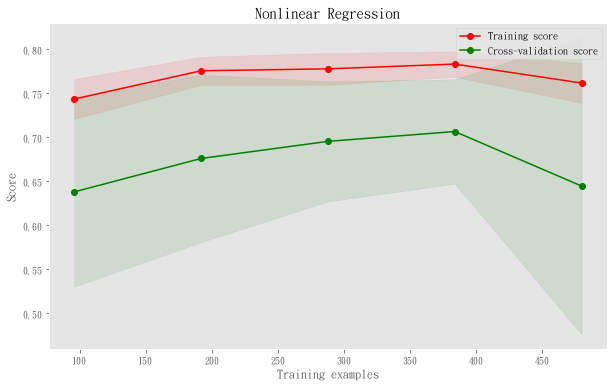

In [48]:
from sklearn.model_selection import KFold,StratifiedKFold
quadratic = PolynomialFeatures(degree=2)
X_raw = X.copy() #原始X_train
X_poly = quadratic.fit_transform(X_raw) #產生x^0, x^1, x^2
cv = KFold(n_splits=4, random_state=None, shuffle=True)
estimator = linear_model.LinearRegression()
plot_learning_curve(estimator, "Nonlinear Regression", X_poly, y, cv=cv,train_sizes=np.linspace(0.2, 1.0, 5))

## OverFitting Repair

## L2 : Ridge

In [49]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1)
ridge.fit(X_train_poly, y_train)

print('各變項參數:', ridge.coef_)
print("MSE: %.2f" % np.mean((ridge.predict(X_test_poly) - y_test.values.ravel()) ** 2)) #.values.ravel()把矩陣轉成一維
print("R Square:",ridge.score(X_test_poly, y_test))

各變項參數: [[0.00000000e+00 1.50381857e+01 1.40610965e-02]]
MSE: 6689321.67
R Square: 0.7687363751390002


<module 'matplotlib.pyplot' from 'C:\\Users\\jas72\\Anaconda3\\envs\\DarrenAI\\lib\\site-packages\\matplotlib\\pyplot.py'>

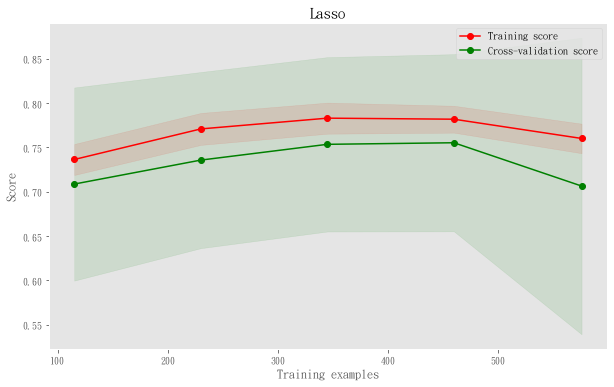

In [50]:
cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = Ridge(alpha=1)

plot_learning_curve(estimator, "Lasso", X_poly, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## L1 : Lasso

In [51]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1)
lasso.fit(X_train_poly, y_train)

print('各變項參數:', lasso.coef_)
print("MSE: %.2f" % np.mean((lasso.predict(X_test_poly) - y_test.values.ravel()) ** 2)) #.values.ravel()把矩陣轉成一維
print("R Square:",lasso.score(X_test_poly, y_test))

各變項參數: [0.00000000e+00 1.50387873e+01 1.40601633e-02]
MSE: 749775.05
R Square: 0.7687372670494657


<module 'matplotlib.pyplot' from 'C:\\Users\\jas72\\Anaconda3\\envs\\DarrenAI\\lib\\site-packages\\matplotlib\\pyplot.py'>

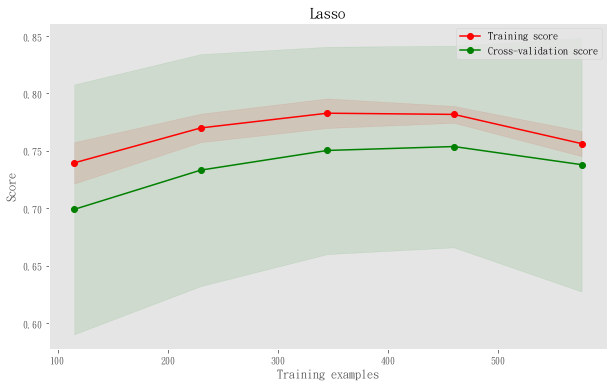

In [52]:
cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = Lasso(alpha=1)

plot_learning_curve(estimator, "Lasso", X_poly, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## L1+L2

In [53]:
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet(alpha=1)
elasticNet.fit(X_train_poly, y_train)

print('各變項參數:', elasticNet.coef_)
print("MSE: %.2f" % np.mean((elasticNet.predict(X_test_poly) - y_test.values.ravel()) ** 2)) #.values.ravel()把矩陣轉成一維
print("R Square:",elasticNet.score(X_test_poly, y_test))

各變項參數: [0.00000000e+00 1.50339451e+01 1.40676730e-02]
MSE: 749798.32
R Square: 0.7687300925047993


<module 'matplotlib.pyplot' from 'C:\\Users\\jas72\\Anaconda3\\envs\\DarrenAI\\lib\\site-packages\\matplotlib\\pyplot.py'>

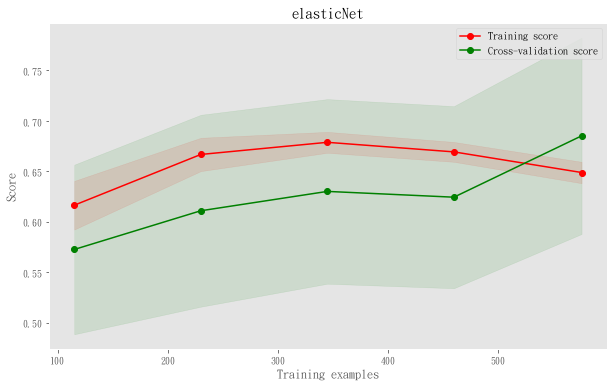

In [54]:
cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = ElasticNet(alpha=1)

plot_learning_curve(estimator, "elasticNet",sc.transform(X), y.values.ravel(), cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))